In [1]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 15.2 MB/s 


In [2]:
# Libraries for Descriptive Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
from collections import Counter


# Deep Learning Tensorflow libraries for text pre-processing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, GRU, Bidirectional
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/DeepLearningBootcamp/

/content/drive/My Drive/Colab Notebooks/DeepLearningBootcamp


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Step 1: Retrieve & Explore Dataset

In [6]:
df = pd.read_csv("SPAMtextmessage20170820_Data.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
# Check number of duplicate entries
print("Duplicate Entries:", df.duplicated().sum())

# Drop duplicate
df.drop_duplicates(inplace = True)

Duplicate Entries: 415


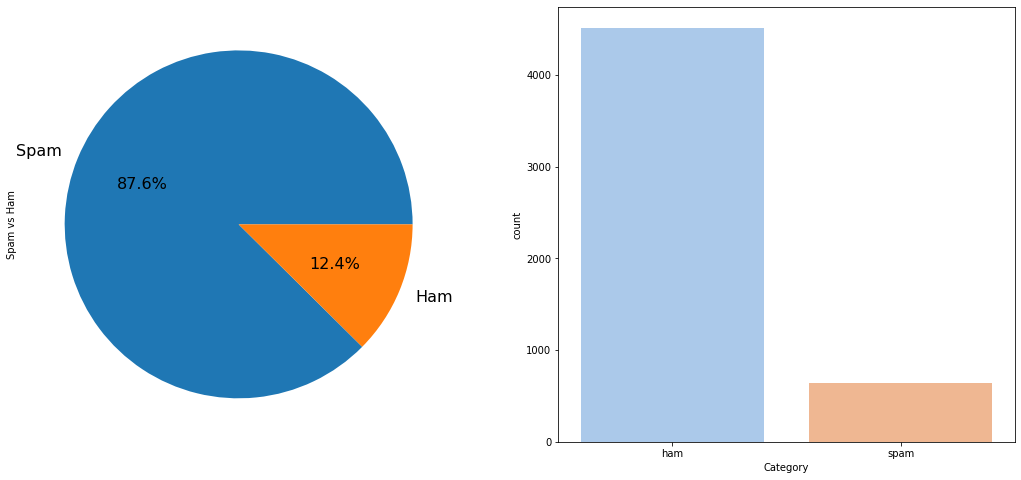

In [9]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
df.Category.value_counts().plot(kind="pie",
                            fontsize=16, 
                            labels=["Spam", "Ham"],
                            ylabel="Spam vs Ham",
                            autopct='%1.1f%%');

plt.subplot(1, 2, 2)
sns.countplot(x="Category",data=df, palette="pastel")
plt.show()

In [10]:
# Encode the column category into numeric label
df['Category'] = df['Category'].astype('category') 
df['Label'] = df['Category'].cat.codes

## Step 2: Clean & Pre-Processed Dataset

In [11]:
from unidecode import unidecode
import re

In [12]:
# Encoding characters coming from other language or special characters
for col in ['Message']:
              df[col] = df[col].apply(unidecode, "utf-8")

In [13]:
def clean_document(text: str):

    # delete any url links in the message
    text = re.sub(r'(?:\s)http[^, ]*', '', text, flags=re.MULTILINE)

    # remove special characters, digits, and whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)

    return text

df['Message_clean'] = df['Message'].apply(clean_document)

In [14]:
# delete words consists of < 3 or > 12 characters

df["Message_clean"] = df["Message_clean"].apply(lambda x: ' '.join([x for x in x.split() if len(x) > 3]))
df["Message_clean"] = df["Message_clean"].apply(lambda x: ' '.join([x for x in x.split() if len(x) < 12]))

In [15]:
import nltk
import spacy
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parse','entity'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def preprocess_document(df):
    df = df.strip()

    # tokenize document
    tokens = wpt.tokenize(df)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # re-create document from filtered tokens
    df = ' '.join(filtered_tokens)
    
    # lemmatize text
    df = nlp(df)
    df = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in df])
    return df

In [17]:
# We keep the original text and create a new column for the pre-processed text 
df['Message_clean'] = df['Message_clean'].apply(preprocess_document)
# df.head()

In [19]:
# lower text
df["Message_clean"] = df["Message_clean"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [20]:
df

,Category,Message,Label,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,0,joke
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp final tkts text receive e...
3,ham,U dun say so early hor... U c already then say...,0,early already
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,do not think go life around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,this time try contact pound prize claim easy c...
5568,ham,Will u b going to esplanade fr home?,0,will go esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,0,bitching act like interested buy something els...


## Word Cloud & Text Exploratory Analysis

In [21]:
ham_corpus = []
for i in df[df['Category'] == 'ham'].Message_clean:
    for j in i.split():
        ham_corpus.append(j.strip())

spam_corpus = []
for i in df[df['Category'] == 'spam'].Message_clean:
    for j in i.split():
        spam_corpus.append(j.strip())

In [22]:
def count_words(corpus):
  counter = Counter(corpus)
  common_words = counter.most_common(15)
  print(dict(common_words))

count_words(ham_corpus)
count_words(spam_corpus)

{'not': 635, 'do': 410, 'go': 295, 'come': 294, 'ltgt': 254, 's': 247, 'know': 242, 'call': 233, 'good': 232, 'like': 231, 'time': 205, 'want': 204, 'love': 199, 'tell': 179, 'well': 175}
{'call': 310, 'free': 185, 'text': 120, 'mobile': 111, 'stop': 108, 'reply': 100, 'claim': 96, 'prize': 78, 'send': 69, 'your': 69, 'service': 60, 'urgent': 56, 'award': 55, 'nokia': 54, 'contact': 53}


In [23]:
# Get all the ham and spam emails
ham_msg = df[df.Category =='ham']
spam_msg = df[df.Category=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.Message_clean.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.Message_clean.to_numpy().tolist())

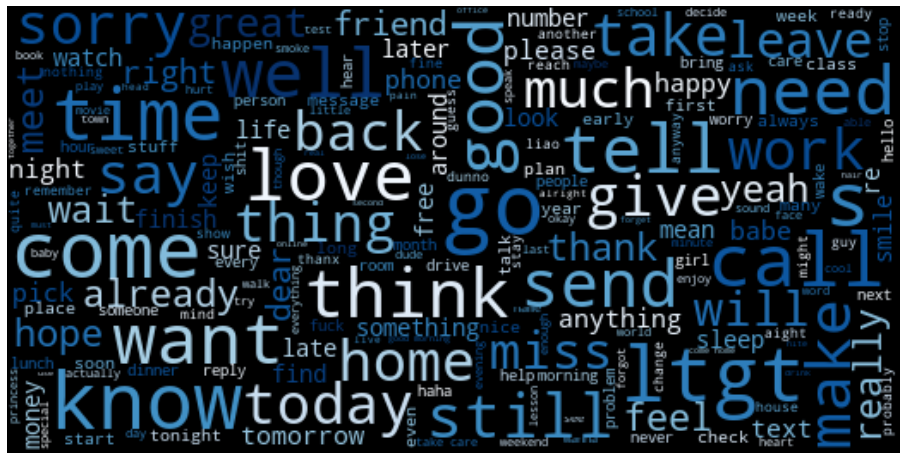

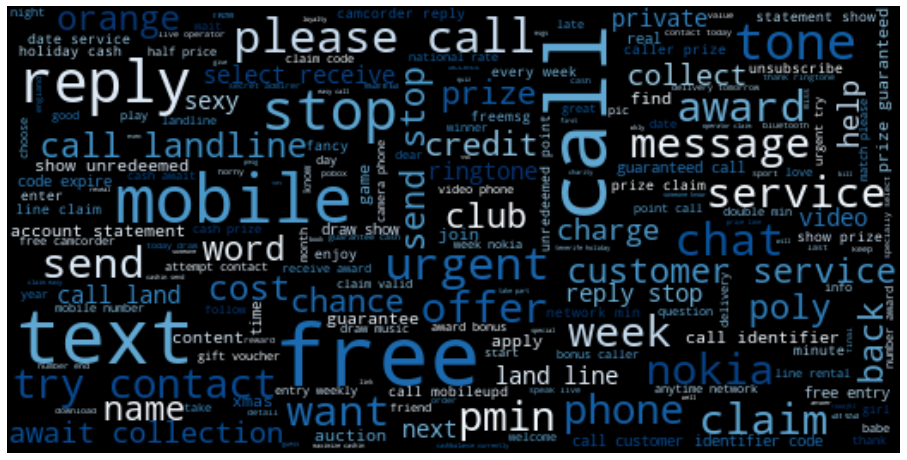

In [24]:
# wordcloud of ham messages
def wordcloud_graph(corpus):
  ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(corpus)
  plt.figure(figsize=(16,10))
  plt.imshow(ham_msg_cloud, interpolation='bilinear')
  plt.axis('off') # turn off axis
  plt.show()

wordcloud_graph(ham_msg_text)
wordcloud_graph(spam_msg_text)

In [25]:
counter_ham_corpus = Counter(ham_corpus)
counter_spam_corpus = Counter(spam_corpus)

In [26]:
df_counter_ham_corpus = pd.DataFrame.from_dict(counter_ham_corpus, orient='index').reset_index()
df_counter_ham_corpus = df_counter_ham_corpus.rename(columns={'index':'event', 0:'count'})

df_counter_spam_corpus = pd.DataFrame.from_dict(counter_spam_corpus, orient='index').reset_index()
df_counter_spam_corpus = df_counter_spam_corpus.rename(columns={'index':'event', 0:'count'})

In [27]:
df_counter_ham_corpus

,event,count
0,jurong,1
1,point,17
2,crazy,12
3,available,12
4,bugis,7
...,...,...
5552,sony,1
5553,salesman,1
5554,pity,1
5555,soany,1


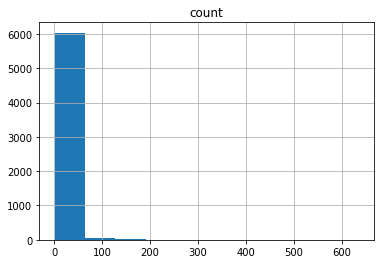

In [ ]:
hist = df_counter_ham_corpus.hist(bins=10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


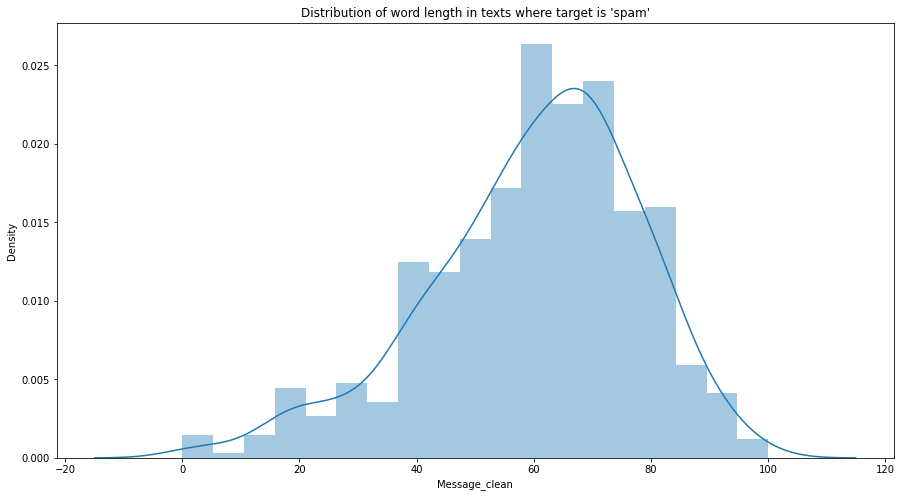

In [29]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = df[df["Category"] == "spam"]["Message_clean"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.sum(x)), ax = ax).set_title("Distribution of word length in texts where target is 'spam'");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


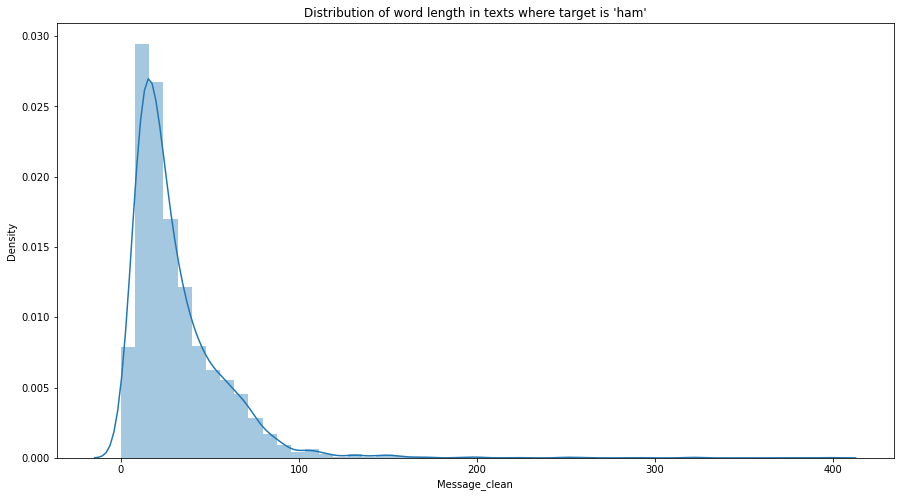

In [30]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = df[df["Category"] == "ham"]["Message_clean"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.sum(x)), ax = ax).set_title("Distribution of word length in texts where target is 'ham'");

## Transform Data for Machine Learning Training

In [55]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts(df.Message_clean)
vocab = tokenizer.word_index
vocabCount = len(vocab)+1

vocabCount

6442

In [56]:
x = df["Message_clean"]
y = df["Label"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print("Train Test Shape: ", train_x.shape, test_x.shape, test_x.shape, test_y.shape)

Train Test Shape:  (4125,) (1032,) (1032,) (1032,)


In [57]:
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(train_x)

tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)

train_x = pad_sequences(tokenized_train, maxlen = None)
test_x = pad_sequences(tokenized_test, maxlen = None)

In [58]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

## Modeling

### Model 1: Bidirectional GRU

In [117]:
model = Sequential()
model.add(Embedding(input_dim = vocabCount, output_dim = 64))
model.add(Bidirectional(GRU(units = 128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.5)))
model.add(Bidirectional(GRU(units = 64, recurrent_dropout = 0.3, dropout = 0.5)))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 64)          412288    
                                                                 
 bidirectional_11 (Bidirecti  (None, None, 256)        148992    
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 689,089
Trainable params: 689,089
Non-t

In [118]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 64,
                    validation_data = (test_x, test_y),
                    epochs = 20,
                    callbacks = [lr_reduce])

Epoch 1/20
65/65 [==============================] - 67s 872ms/step - loss: 0.1728 - accuracy: 0.9462 - val_loss: 0.0909 - val_accuracy: 0.9797 - lr: 0.0100
Epoch 2/20
65/65 [==============================] - 56s 859ms/step - loss: 0.0326 - accuracy: 0.9910 - val_loss: 0.1185 - val_accuracy: 0.9758 - lr: 0.0100
Epoch 3/20
65/65 [==============================] - 56s 861ms/step - loss: 0.0258 - accuracy: 0.9939 - val_loss: 0.1370 - val_accuracy: 0.9767 - lr: 0.0100
Epoch 4/20
65/65 [==============================] - 55s 849ms/step - loss: 0.0142 - accuracy: 0.9961 - val_loss: 0.0986 - val_accuracy: 0.9767 - lr: 0.0050
Epoch 5/20
65/65 [==============================] - 55s 848ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.1210 - val_accuracy: 0.9797 - lr: 0.0050
Epoch 6/20
65/65 [==============================] - 55s 846ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.1401 - val_accuracy: 0.9777 - lr: 0.0025
Epoch 7/20
65/65 [==============================] - 55s 850ms/st

In [119]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

129/129 [==============================] - 12s 82ms/step - loss: 0.0018 - accuracy: 0.9995
Model accuracy on the train set:  0.999515175819397
33/33 [==============================] - 2s 57ms/step - loss: 0.1589 - accuracy: 0.9787
Model accuracy on the test set:  0.9786821603775024


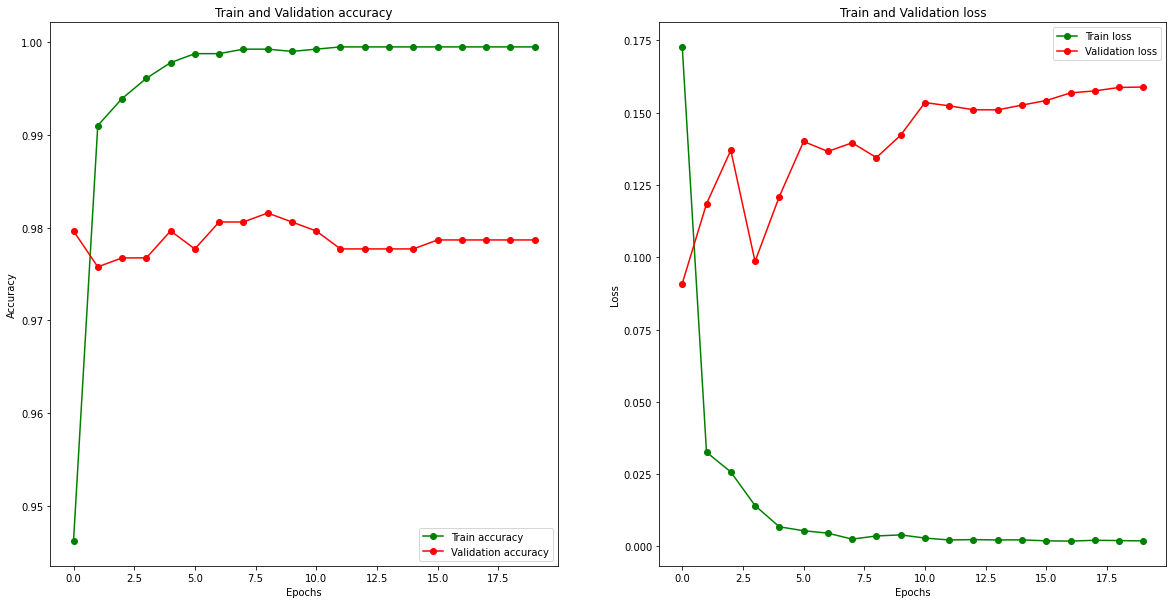

In [120]:
epochs = [i for i in range(20)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [121]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       901
           1       0.00      0.00      0.00       131

    accuracy                           0.87      1032
   macro avg       0.44      0.50      0.47      1032
weighted avg       0.76      0.87      0.81      1032



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
max_accuracy = 0
best_threshold = 0

for threshold in np.arange(0.5, 0.99, 0.01):
    prediction=(prediction>threshold)
    score=accuracy_score(test_y,prediction)
    if score > max_accuracy:
        max_accuracy = score
        best_threshold = threshold
    else:
        pass

print("The best accuracy {}% is achieved when the threshold is set at {}.".format(round(max_accuracy*100, 5), best_threshold))

The best accuracy 97.86822% is achieved when the threshold is set at 0.5.


In [123]:
prediction=(prediction>best_threshold)

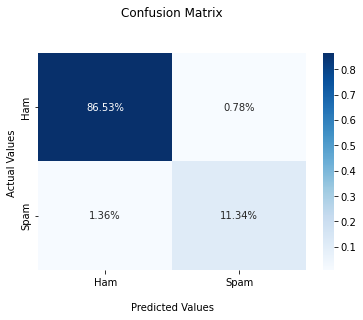

In [124]:
cf_matrix=confusion_matrix(test_y,prediction)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Ham','Spam'])
ax.yaxis.set_ticklabels(['Ham','Spam'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [125]:
# save the model to file
model.save('Classification_BidirectionalGRU_ImbalanceData.h5')

### Model 2: GRU

In [108]:
model = Sequential()
model.add(Embedding(input_dim = vocabCount, output_dim = 64))
model.add(GRU(units = 128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.5))
model.add(GRU(units = 64, recurrent_dropout = 0.3, dropout = 0.5))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          412288    
                                                                 
 gru_15 (GRU)                (None, None, 128)         74496     
                                                                 
 gru_16 (GRU)                (None, 64)                37248     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 526,145
Trainable params: 526,145
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 64,
                    validation_data = (test_x, test_y),
                    epochs = 20,
                    callbacks = [lr_reduce])

Epoch 1/20
65/65 [==============================] - 36s 462ms/step - loss: 0.1493 - accuracy: 0.9513 - val_loss: 0.0841 - val_accuracy: 0.9806 - lr: 0.0100
Epoch 2/20
65/65 [==============================] - 29s 452ms/step - loss: 0.0423 - accuracy: 0.9869 - val_loss: 0.1044 - val_accuracy: 0.9787 - lr: 0.0100
Epoch 3/20
65/65 [==============================] - 29s 444ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.1474 - val_accuracy: 0.9622 - lr: 0.0100
Epoch 4/20
65/65 [==============================] - 29s 443ms/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.1229 - val_accuracy: 0.9787 - lr: 0.0050
Epoch 5/20
65/65 [==============================] - 29s 442ms/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.1598 - val_accuracy: 0.9777 - lr: 0.0050
Epoch 6/20
65/65 [==============================] - 29s 441ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.1421 - val_accuracy: 0.9777 - lr: 0.0025
Epoch 7/20
65/65 [==============================] - 29s 441ms/st

In [110]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

129/129 [==============================] - 6s 42ms/step - loss: 0.0020 - accuracy: 0.9995
Model accuracy on the train set:  0.999515175819397
33/33 [==============================] - 1s 29ms/step - loss: 0.1509 - accuracy: 0.9777
Model accuracy on the test set:  0.9777131676673889


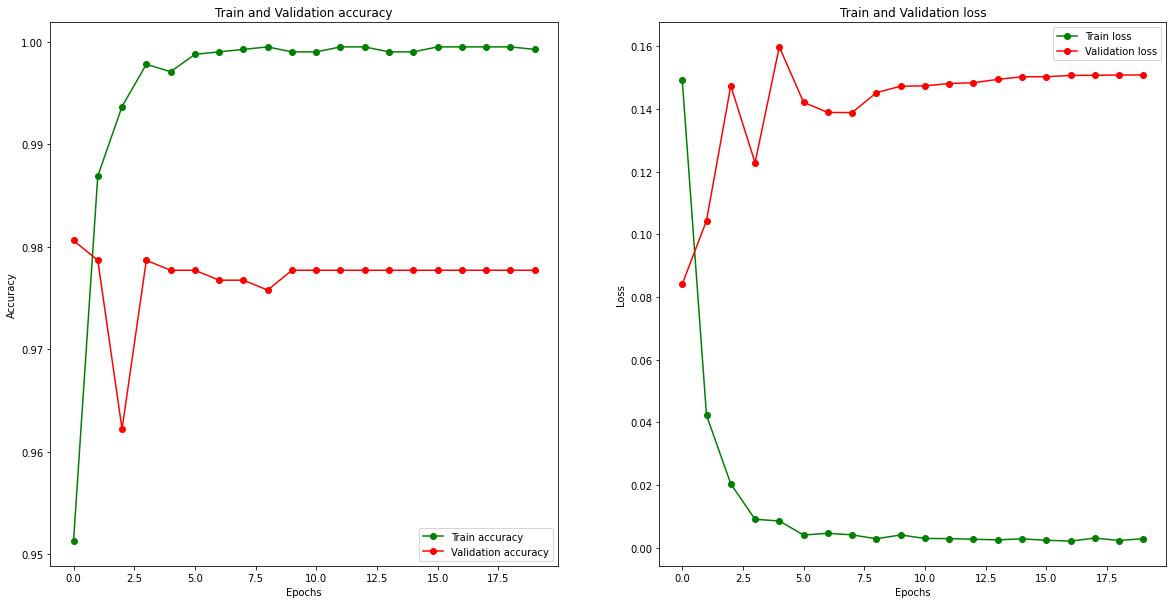

In [111]:
epochs = [i for i in range(20)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [112]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       901
           1       0.00      0.00      0.00       131

    accuracy                           0.87      1032
   macro avg       0.44      0.50      0.47      1032
weighted avg       0.76      0.87      0.81      1032



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
max_accuracy = 0
best_threshold = 0

for threshold in np.arange(0.5, 0.99, 0.01):
    prediction=(prediction>threshold)
    score=accuracy_score(test_y,prediction)
    if score > max_accuracy:
        max_accuracy = score
        best_threshold = threshold
    else:
        pass

print("The best accuracy {}% is achieved when the threshold is set at {}.".format(round(max_accuracy*100, 5), best_threshold))

The best accuracy 97.77132% is achieved when the threshold is set at 0.5.


In [114]:
prediction=(prediction>best_threshold)

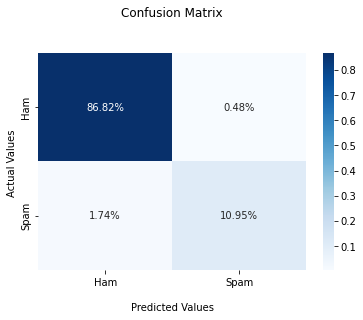

In [115]:
cf_matrix=confusion_matrix(test_y,prediction)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Ham','Spam'])
ax.yaxis.set_ticklabels(['Ham','Spam'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [116]:
# save the model to file
model.save('Classification_GRU_ImbalanceData.h5')

### Model 3: GRU with Glove Embedding

In [95]:
GLOVE_EMBEDDING = "glove.twitter.27B.100d.txt"

In [96]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))

embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(6012, len(word_index))+1

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 6012:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [98]:
model = Sequential()

model.add(Embedding(5590, output_dim = 100, weights = [embedding_matrix], trainable = False))

model.add(GRU(units = 128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.5))

model.add(GRU(units = 64, recurrent_dropout = 0.3, dropout = 0.5))

model.add(Dense(units = 32, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01), loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         559000    
                                                                 
 gru_13 (GRU)                (None, None, 128)         88320     
                                                                 
 gru_14 (GRU)                (None, 64)                37248     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 686,681
Trainable params: 127,681
Non-trainable params: 559,000
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [99]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 64,
                    validation_data = (test_x, test_y),
                    epochs = 20,
                    callbacks = [lr_reduce])

Epoch 1/20
65/65 [==============================] - 33s 435ms/step - loss: 0.1722 - accuracy: 0.9362 - val_loss: 0.1603 - val_accuracy: 0.9399 - lr: 0.0100
Epoch 2/20
65/65 [==============================] - 28s 426ms/step - loss: 0.1244 - accuracy: 0.9590 - val_loss: 0.1121 - val_accuracy: 0.9661 - lr: 0.0100
Epoch 3/20
65/65 [==============================] - 27s 421ms/step - loss: 0.1069 - accuracy: 0.9622 - val_loss: 0.1837 - val_accuracy: 0.9535 - lr: 0.0100
Epoch 4/20
65/65 [==============================] - 28s 430ms/step - loss: 0.0988 - accuracy: 0.9668 - val_loss: 0.0893 - val_accuracy: 0.9700 - lr: 0.0100
Epoch 5/20
65/65 [==============================] - 28s 427ms/step - loss: 0.0941 - accuracy: 0.9721 - val_loss: 0.0964 - val_accuracy: 0.9661 - lr: 0.0100
Epoch 6/20
65/65 [==============================] - 28s 432ms/step - loss: 0.1004 - accuracy: 0.9663 - val_loss: 0.0936 - val_accuracy: 0.9719 - lr: 0.0100
Epoch 7/20
65/65 [==============================] - 28s 427ms/st

In [100]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

129/129 [==============================] - 6s 43ms/step - loss: 0.0416 - accuracy: 0.9891
Model accuracy on the train set:  0.9890909194946289
33/33 [==============================] - 1s 31ms/step - loss: 0.0807 - accuracy: 0.9738
Model accuracy on the test set:  0.9738371968269348


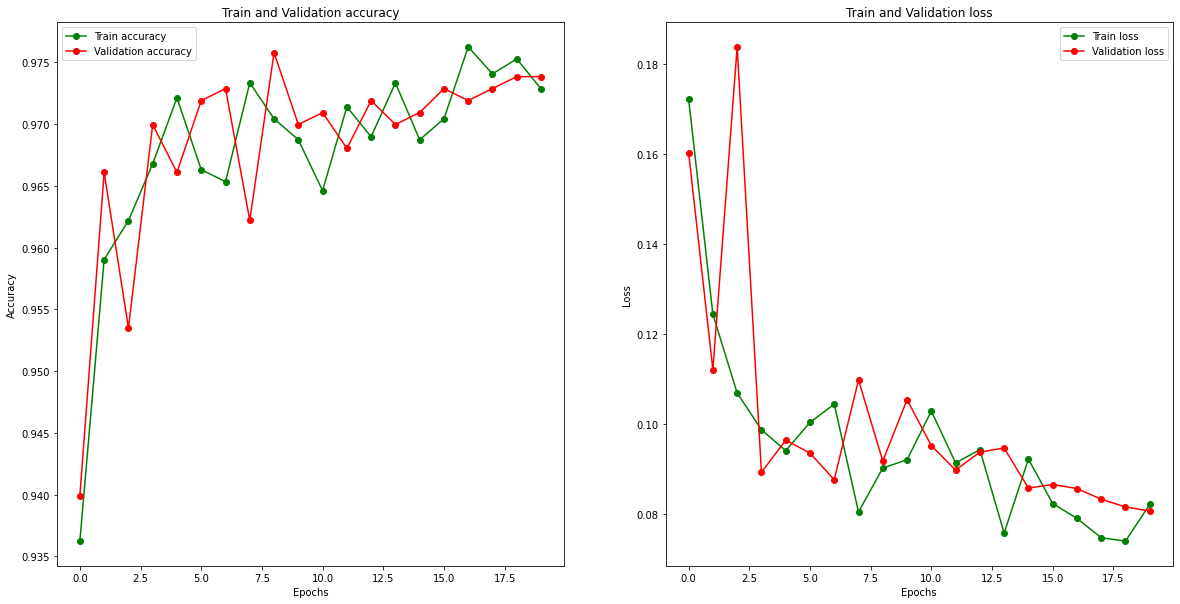

In [101]:
epochs = [i for i in range(20)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Validation accuracy")
ax[0].set_title("Train and Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Validation loss")
ax[1].set_title("Train and Validation loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [102]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       901
           1       0.00      0.00      0.00       131

    accuracy                           0.87      1032
   macro avg       0.44      0.50      0.47      1032
weighted avg       0.76      0.87      0.81      1032



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [103]:
max_accuracy = 0
best_threshold = 0

for threshold in np.arange(0.5, 0.99, 0.01):
    prediction=(prediction>threshold)
    score=accuracy_score(test_y,prediction)
    if score > max_accuracy:
        max_accuracy = score
        best_threshold = threshold
    else:
        pass

print("The best accuracy {}% is achieved when the threshold is set at {}.".format(round(max_accuracy*100, 5), best_threshold))

The best accuracy 97.38372% is achieved when the threshold is set at 0.5.


In [104]:
prediction=(prediction>best_threshold)

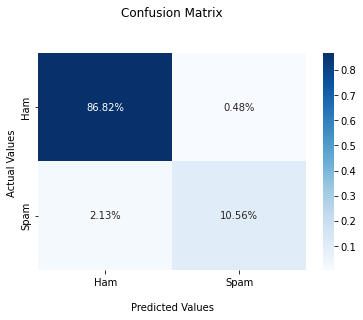

In [106]:
cf_matrix=confusion_matrix(test_y,prediction)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Ham','Spam'])
ax.yaxis.set_ticklabels(['Ham','Spam'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [107]:
# save the model to file
model.save('Classification_BidirectionalGRU_GloveEmbedding_ImbalanceData.h5')